In [1]:
# loading packages 
import datacube 
from deafrica_tools.dask import create_local_dask_cluster

In [2]:
# connecting to the datacube 
dc = datacube.Datacube(app='section_1')

In [3]:
# standard load function for data
data = dc.load(product='gm_s2_annual',
              measurements=['red','nir'],
              x=(24, 25.5),
              y=(-21.5, -20),
              time=('2020-01-01', '2020-12-31'))

# return data 
data


<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1308 1391 1433 1424 ... 1771 1846 1760 1742
    nir          (time, y, x) uint16 2148 2309 2386 2358 ... 2675 2752 2689 2646
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [4]:
# enabling dask
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36971 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37747 Dashboard: /user/mseehaber@frontiersi.com.au/proxy/36971/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [ ]:
################# break 

In [5]:
# lazy loading data through dask chunks parameter
lazy_data = dc.load(product='gm_s2_annual',
                   measurements=['red','nir'],
                   x=(24, 25.5),
                   y=(-21.5, -20),
                   time=('2020-01-01', '2020-12-31'),
                   dask_chunks={'time':1,'x':3000, 'y':3000})
# return data
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [6]:
# viewing dask chunks
lazy_data.red.data

dask.array<dc_load_red, shape=(1, 17925, 14473), dtype=uint16, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>

In [7]:
# loading lazy data 
loaded_data = lazy_data.load()

In [8]:
loaded_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1308 1391 1433 1424 ... 1771 1846 1760 1742
    nir          (time, y, x) uint16 2148 2309 2386 2358 ... 2675 2752 2689 2646
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [9]:
################# break 

In [10]:
# adding nir band to the dc.load command to explore lazy operations
lazy_data = dc.load(product='gm_s2_annual',
                    measurements=['red', 'green', 'blue', 'nir'],
                    x=(24, 25.5),
                    y=(-21.5, -20),
                    time=("2018-01-01", "2018-12-31"),
                    dask_chunks={'time': 1, 'x': 3000, 'y': 3000})

lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

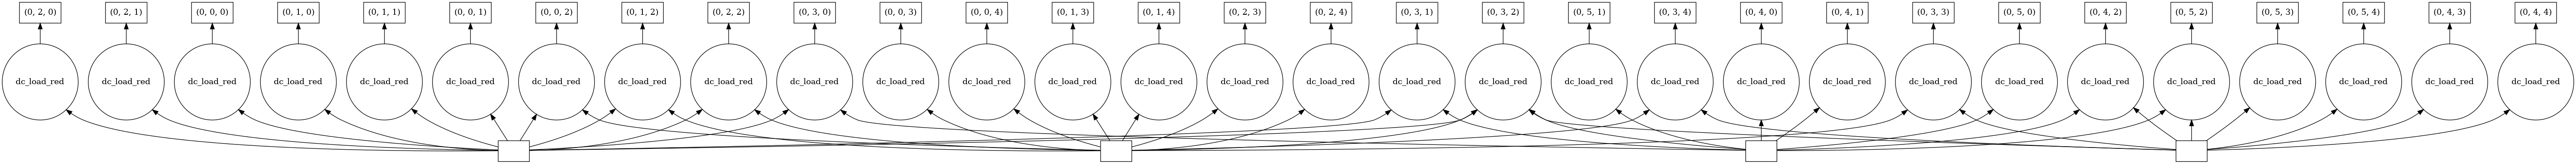

In [11]:
# visualise the task graph
lazy_data.red.data.visualize()

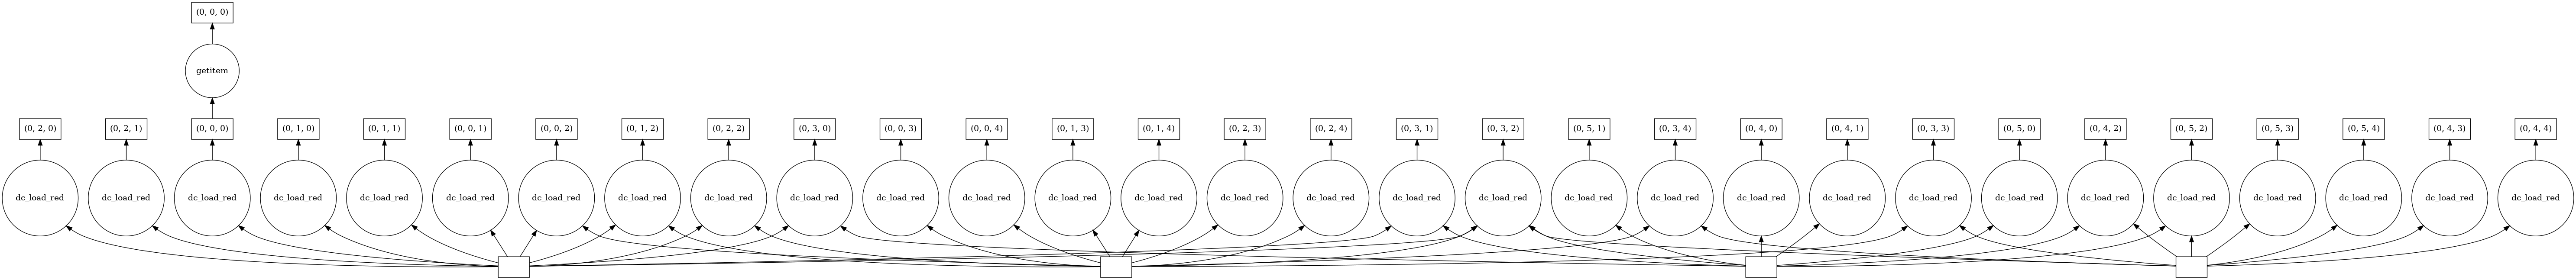

In [14]:
# requesting small portion of red band 
extract_from_red = lazy_data.red[:, 100:200, 100:200]
extract_from_red.data.visualize()

In [15]:
# extracting relevant data from the Dask array
lazy_red_subset = extract_from_red.load()
data_red_subset = data.red[:, 100:200, 100:200]

print(f"The loaded arrays match: {lazy_red_subset.equals(data_red_subset)}")

The loaded arrays match: False


In [16]:
# calcualte NDVI using red and nir bands from array
band_diff = lazy_data.nir - lazy_data.red
band_sum = lazy_data.nir + lazy_data.red

# added ndvi dask array to the lazy_data dataset
lazy_data['ndvi'] = band_diff / band_sum

In [17]:
# load data
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

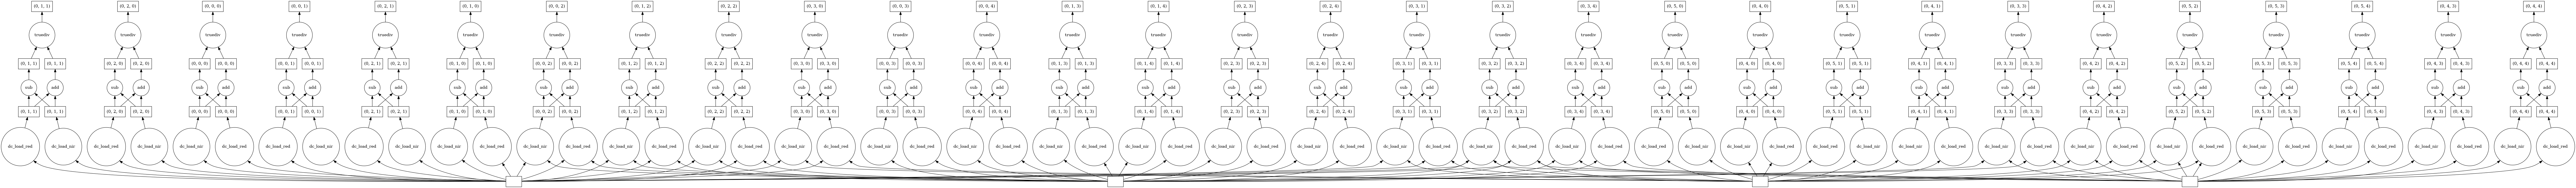

In [18]:
# visualise task graph
lazy_data.ndvi.data.visualize()

In [20]:
# calculates NDVI values through .load()
ndvi_load = lazy_data.ndvi.load()
ndvi_load

<xarray.DataArray 'ndvi' (time: 1, y: 17925, x: 14473)>
array([[[0.34023759, 0.33039389, 0.32077593, ..., 0.37083061,
         0.38180611, 0.37719008],
        [0.33235381, 0.33006912, 0.32352124, ..., 0.36498708,
         0.36280884, 0.38525155],
        [0.31681217, 0.3295325 , 0.32962448, ..., 0.36790286,
         0.35850274, 0.36588629],
        ...,
        [0.19612476, 0.1977664 , 0.20513408, ..., 0.23719165,
         0.26922088, 0.2815534 ],
        [0.19981128, 0.20527046, 0.20905764, ..., 0.2352666 ,
         0.25160983, 0.2643065 ],
        [0.20236407, 0.20495443, 0.20352341, ..., 0.23283311,
         0.25068493, 0.25750174]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933

In [21]:
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 17925, x: 14473)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.681e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 0.3402 0.3304 0.3208 ... 0.2507 0.2575
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref